# **Clasificador de estilos artÍsticos en pinturas**

**Integrantes:  Valentina Pérez, Sneider Sánchez, Dana Villamizar**

## Motivación

Este proyecto busca aplicar deep learning en la clasificación de estilos artísticos, combinando un reto técnico con la oportunidad de acercar el arte a la inteligencia artificial.

## Objetivos

### Objetivo general:
Clasificación de pinturas según su estilo artístico empleando técnicas de deep learning aplicadas a imágenes del dataset ArtBench.

### Objetivos específicos:

* Usar un modelo de deep learning para extraer características relevantes de las pinturas.

* Optimizar el modelo mediante regularización, ajuste de hiperparámetros y data augmentation.

* Comparar el rendimiento de los modelos con y sin selección de características automatizada.

* Evaluar el desempeño del modelo con métricas de clasificación.

## Identificación del conjunto de datos

Se utiliza el dataset ArtBench-10, disponible públicamente en Hugging Face bajo el repositorio zguo0525/ArtBench.
Este conjunto de datos fue diseñado específicamente para la clasificación de estilos artísticos en pinturas.

Características principales del dataset:

* Cantidad total de imágenes: 60,000.

* Dimensión de las imágenes: 256 × 256 píxeles (RGB).

* División: 50,000 imágenes para entrenamiento y 10,000 para prueba.

* Número de clases: 10 estilos artísticos: Expressionism, Impressionism, Post-Impressionism, Renaissance, Romanticism, Realism, Art Nouveau, Surrealism, Ukiyo-e, Baroque.

## **Librerías**

In [ ]:
!pip install datasets tensorflow numpy matplotlib scikit-learn

from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import seaborn as sns
import pandas as pd

## **Carga del dataset**

Etiqueta: 0 | Imagen shape: (256, 256, 3)


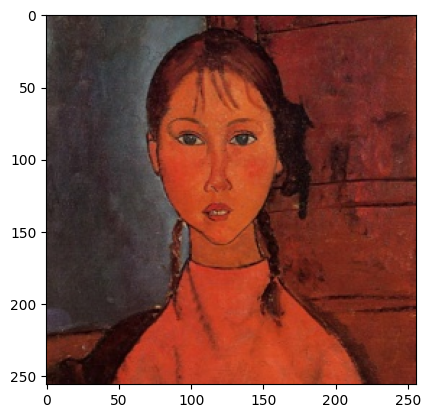

In [ ]:
#Se carga el dataset desde HuggingFace
dataset = load_dataset("zguo0525/ArtBench")

#Se obtienen las divisiones
train_ds = dataset["train"]
test_ds = dataset["test"]

#Ejemplo
ej = train_ds[1]
img_array = np.array(ej["image"])
print("Etiqueta:", ej["label"], "| Imagen shape:", img_array.shape)
plt.imshow(img_array)
plt.show()

## **Exploración del dataset**

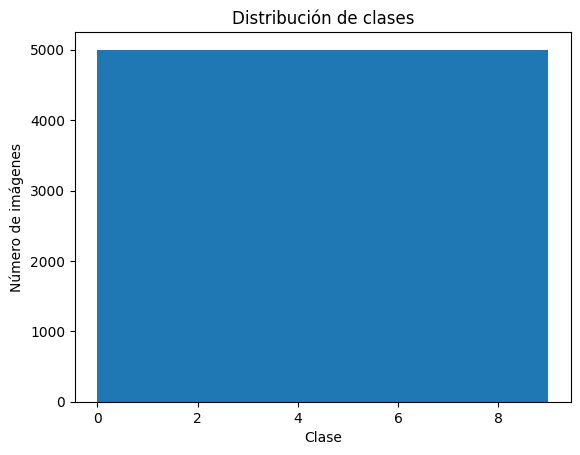

In [ ]:
#Distrubución de clases en training

labels = [example["label"] for example in dataset["train"]]
plt.hist(labels, bins=len(set(labels)))
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.show()

#50k para training, donde cada clase tiene el 10%

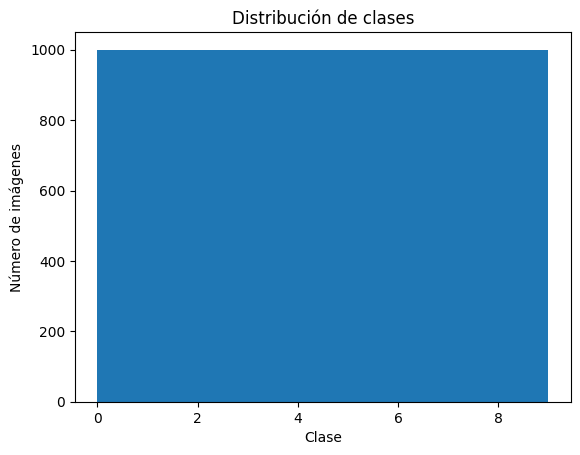

In [ ]:
#Distrubución de clases en test

labels = [example["label"] for example in dataset["test"]]
plt.hist(labels, bins=len(set(labels)))
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.show()

#10k para test, donde cada clase tiene el 10%

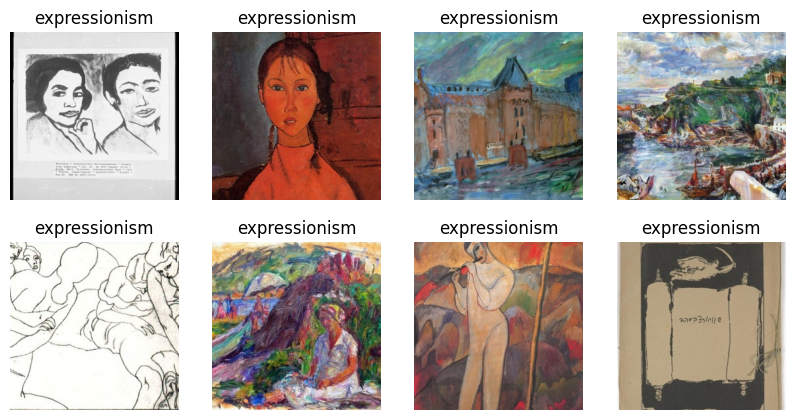

In [ ]:
#Muestras del dataset

#Primero se hace el mapeo de labels.
class_names = train_ds.features["label"].names

fig, axes = plt.subplots(2, 4, figsize=(10,5))
for i, (example) in enumerate(dataset["train"].select(range(8))):
    img = example["image"]
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(f"{class_names[example['label']]}")
    axes[i//4, i%4].axis("off")
plt.show()


## **Preprocesamiento**

In [ ]:
IMG_SIZE = 224

#Se redimensionan a 224x224 y se normalizan [0,1]
def preprocess_tf(example):
    #Se realiza la siguiente conversión: PIL -> NumPy -> Tensor
    image = np.array(example["image"])
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) #Redimensión
    image = tf.cast(image, tf.float32) / 255.0   # normalización [0,1]
    label = example["label"]
    return {"image": image, "label": label}

#Se aplica una transformación eficiente sin cargar todo a memoria
#Para que colab no explote c:
train_tf = dataset["train"].with_transform(preprocess_tf)
test_tf  = dataset["test"].with_transform(preprocess_tf)

#Se crean los nuevos datasets para Keras
tf_train = train_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=32,
    shuffle=True
)

tf_test = test_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=32
)


## **Aplicaciones**

### **CNN a mano**


In [ ]:
IMG_SIZE = 160  #Bajé la dimensión de las imagenes porque sino explota al ser una CNN

#Se redimensionan a 96x96 y se normalizan [0,1]
def preprocess_cnn(example):
    #Se realiza la siguiente conversión: PIL -> NumPy -> Tensor
    image = np.array(example["image"])
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #Redimensión
    image = tf.cast(image, tf.float32) / 255.0
    label = example["label"]
    return {"image": image, "label": label}

#Transformación cheta para no explotar
train_tf = dataset["train"].with_transform(preprocess_cnn)
test_tf = dataset["test"].with_transform(preprocess_cnn)

#Se crea el dataset de train
tf_train = train_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64,
    shuffle=True
).cache().prefetch(tf.data.AUTOTUNE)

#Se crea el dataset de test
tf_test = test_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64
).cache().prefetch(tf.data.AUTOTUNE)

I0000 00:00:1761804428.791872      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',  # porque las etiquetas son enteras
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251,754 (50.55 MB)

 Trainable params: 13,250,602 (50.55 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    tf_train,
    validation_data=tf_test,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15


I0000 00:00:1761804453.577027     213 service.cc:148] XLA service 0x78a6a0008120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761804453.578138     213 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761804454.471244     213 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/782 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.1367 - loss: 3.5166   

I0000 00:00:1761804465.355095     213 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 191ms/step - accuracy: 0.2514 - loss: 2.2717 - val_accuracy: 0.1752 - val_loss: 3.1705
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.3742 - loss: 1.7538 - val_accuracy: 0.2924 - val_loss: 2.4492
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.4111 - loss: 1.6307 - val_accuracy: 0.4123 - val_loss: 1.6219
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.4631 - loss: 1.4746 - val_accuracy: 0.3521 - val_loss: 1.9464
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.4951 - loss: 1.3852 - val_accuracy: 0.4084 - val_loss: 1.7651
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.5515 - loss: 1.2366 - val_accuracy: 0.3936 - val_loss: 1.9532
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.6088 - loss: 1.0910 - val_accuracy: 0.4310 - val_loss: 1.7784
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.6914 - loss: 0.8615 - val_accur

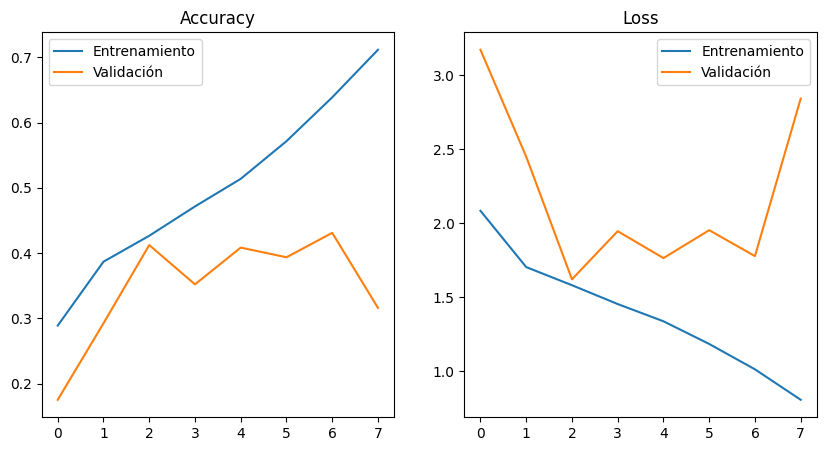

In [ ]:
#Figurita para ver el acc y loss
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
#Evaluación del modelo CNN
loss, acc = model.evaluate(tf_test)
print(f"\n✅ Loss en test: {loss:.4f}")
print(f"✅ Accuracy en test: {acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3758 - loss: 1.7147

✅ Loss en test: 1.6219
✅ Accuracy en test: 0.4123


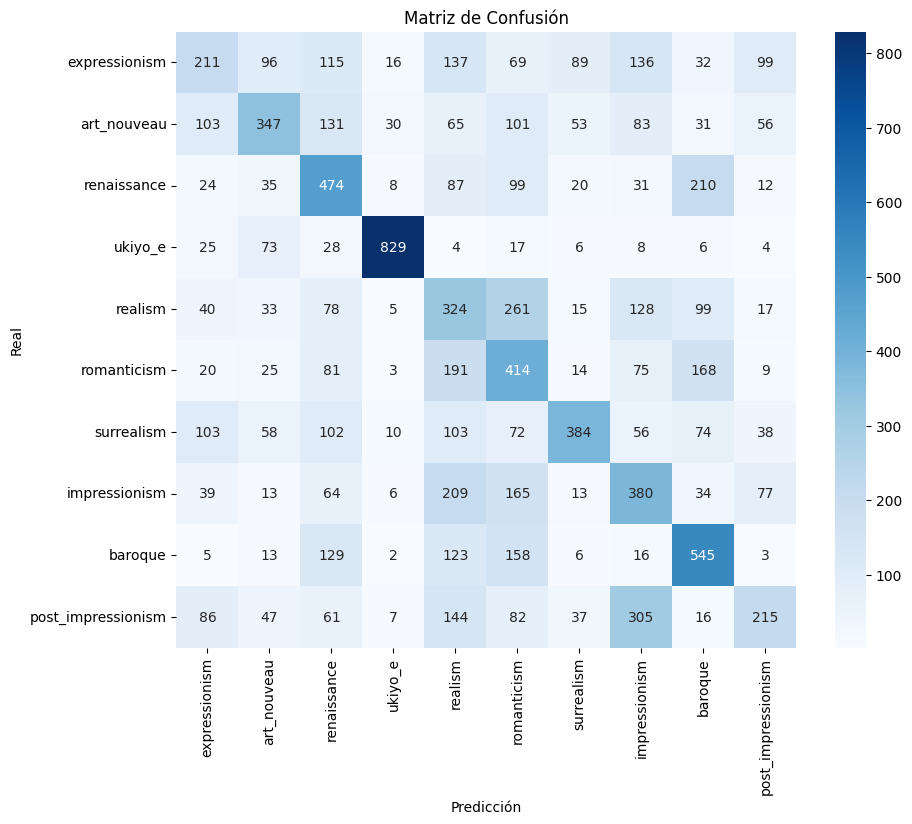

In [ ]:
#Matriz de confusión cheta
y_true = []
y_pred = []

for batch in tf_test:
    images, labels = batch
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [ ]:
#Reporte de clasifiación del modelo
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))


Reporte de clasificación:
                    precision    recall  f1-score   support

     expressionism       0.32      0.21      0.25      1000
       art_nouveau       0.47      0.35      0.40      1000
       renaissance       0.38      0.47      0.42      1000
           ukiyo_e       0.91      0.83      0.87      1000
           realism       0.23      0.32      0.27      1000
       romanticism       0.29      0.41      0.34      1000
        surrealism       0.60      0.38      0.47      1000
     impressionism       0.31      0.38      0.34      1000
           baroque       0.45      0.55      0.49      1000
post_impressionism       0.41      0.21      0.28      1000

          accuracy                           0.41     10000
         macro avg       0.44      0.41      0.41     10000
      weighted avg       0.44      0.41      0.41     10000



In [ ]:
# AUC ROC
#one hot encoding
y_true_bin = label_binarize(y_true, classes=range(10))
y_prob = model.predict(tf_test, verbose=0)

auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
print(f"AUC (macro, multiclase): {auc:.4f}")

AUC (macro, multiclase): 0.8364


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


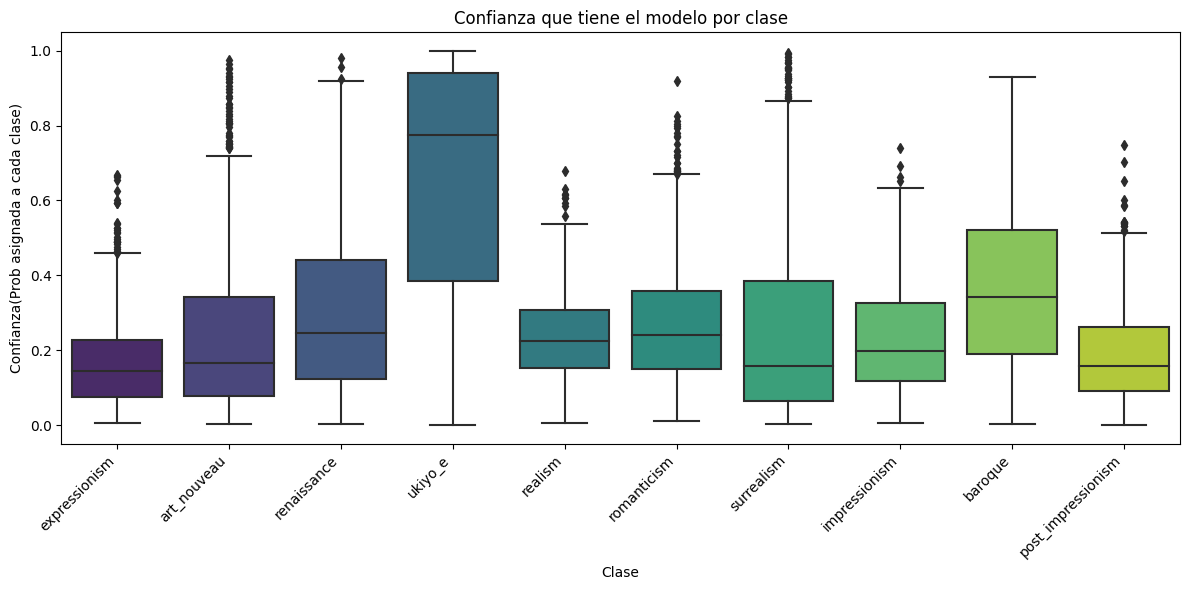

In [ ]:
#se obtienen preds
y_probs = model.predict(tf_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.concatenate([y for x, y in tf_test], axis=0)

# valores de confianza del modelo por clase
true_confidences = [y_probs[i, y_true[i]] for i in range(len(y_true))]

#Labels
class_names = [
    "expressionism", "art_nouveau", "renaissance", "ukiyo_e", "realism",
    "romanticism", "surrealism", "impressionism", "baroque", "post_impressionism"
]

#Dataframe para graficar
df_box = pd.DataFrame({
    "True Label": [class_names[i] for i in y_true],
    "Confidence": true_confidences
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_box, x="True Label", y="Confidence", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Confianza que tiene el modelo por clase")
plt.ylabel("Confianza(Prob asignada a cada clase)")
plt.xlabel("Clase")
plt.tight_layout()
plt.show()

In [ ]:
model.save("/kaggle/working/artbench_cnn.h5")